## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [32]:
import pandas as pd
import numpy as np 
import plotnine as p9
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet , LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

In [2]:
data = pd.read_csv(r"https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1")

## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [3]:
X_1 = data[["age", "chol"]]
y_1 = data["diagnosis"]

ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),],
  remainder = "passthrough"
)

pipe1 = Pipeline(
  [("preprocessing", ct),
  ("logistic_regression", LogisticRegression())]
)

In [4]:
fitted_1 = pipe1.fit(X_1, y_1)
coef1 = fitted_1.named_steps["logistic_regression"].coef_

int1_1 = fitted_1.named_steps["logistic_regression"].intercept_

w1age_1 = coef1[0,[0]]
w2chol_1 = coef1[0,[1]]

In [5]:
# y(0) = W1*age + W2+chol + int 

(0 - (w1age_1 * 55) - int1_1)/ w2chol_1

array([367.8748898])

In [6]:
(0.9542 - (w1age_1 *55) - int1_1) / w2chol_1

array([897.62150021])

## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [7]:
pipe2 = Pipeline(
  [("preprocessing", ct),
  ("LDA", LinearDiscriminantAnalysis())]
)

In [15]:
fitted_2 = pipe2.fit(X_1, y_1)
coef2 = fitted_2.named_steps["LDA"].coef_

int1_2 = fitted_2.named_steps["LDA"].intercept_

w1age_2 = coef2[0,[0]]
w2chol_2 = coef2[0,[1]]

In [16]:
# y(0) = W1*age + W2+chol + int 

(0 - (w1age_2 * 55) - int1_2)/ w2chol_2

array([368.23535753])

## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [14]:
pipe3 = Pipeline(
  [("preprocessing", ct),
  ("SVC", SVC(kernel='linear', C=1.0))]
)

In [17]:
fitted_3 = pipe3.fit(X_1, y_1)
coef3 = fitted_3.named_steps["SVC"].coef_

int1_3 = fitted_3.named_steps["SVC"].intercept_

w1age_3 = coef3[0,[0]]
w2chol_3 = coef3[0,[1]]

In [18]:
# y(0) = W1*age + W2+chol + int 

(0 - (w1age_3 * 55) - int1_3)/ w2chol_3

array([312.70052778])

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

In [88]:
xname, yname = "age", "chol"
models = {
    "Logistic": pipe1,
    "LDA": pipe2,
    "SVC": pipe3,         
}

In [89]:
x1, x99 = np.nanpercentile(data[xname], [1, 99])
y1, y99 = np.nanpercentile(data[yname], [1, 99])
padx = (x99 - x1) * 0.05 or 1.0
pady = (y99 - y1) * 0.05 or 1.0
xs = np.linspace(x1 - padx, x99 + padx, 400)
ys = np.linspace(y1 - pady, y99 + pady, 400)
xx, yy = np.meshgrid(xs, ys)

In [90]:
grid = pd.DataFrame({xname: xx.ravel(), yname: yy.ravel()})
for col in X_1.columns:
    if col in (xname, yname): 
        continue
    if pd.api.types.is_numeric_dtype(X_1[col]):
        grid[col] = float(np.nanmedian(X_1[col]))
    else:
        grid[col] = X_1[col].mode(dropna=True).iat[0]

# make sure column order matches training schema
grid = grid.reindex(columns=X_1.columns)

In [97]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(9, 6))

codes, class_labels = pd.factorize(data["diagnosis"])  # -> ints + label order
ax.scatter(data[xname], data[yname], c=codes, cmap="Set1",
           edgecolors="k", s=40, alpha=0.6, zorder=2)

class_handles = [
    Line2D([0],[0], marker='o', color='w',
           markerfacecolor=plt.cm.Set1(i), markeredgecolor='k',
           markersize=8, label=lab)
    for i, lab in enumerate(class_labels)
]


In [98]:
from matplotlib.lines import Line2D

# styles for legend proxies
legend_styles = {
    "LDA":      dict(color="tab:green",  lw=2.5, ls="-."),
    "SVC":      dict(color="tab:orange", lw=2.0, ls=":"),
    "Logistic": dict(color="tab:blue",   lw=3.0, ls="--"),
}

# same styles translated to contour kwargs
contour_styles = {
    name: dict(colors=st["color"], linewidths=st["lw"], linestyles=st["ls"])
    for name, st in legend_styles.items()
}

boundary_handles = []
for name in ["LDA", "SVC", "Logistic"]:
    model = models[name]
    # decision surface for this model
    if hasattr(model, "decision_function"):
        s = model.decision_function(grid)
        if getattr(s, "ndim", 1) > 1:  # multiclass guard
            s = s[:, 1]
        Z = s.reshape(xx.shape); levels = [0.0]
    else:
        proba = model.predict_proba(grid)
        idx = 1 if proba.shape[1] > 1 else 0
        Z = proba[:, idx].reshape(xx.shape); levels = [0.5]

    # draw boundary with proper contour kwargs
    ax.contour(xx, yy, Z, levels=levels, zorder=6, **contour_styles[name])

    # proxy handle for legend
    st = legend_styles[name]
    boundary_handles.append(Line2D([0], [0], color=st["color"], lw=st["lw"],
                                   ls=st["ls"], label=f"{name} boundary"))


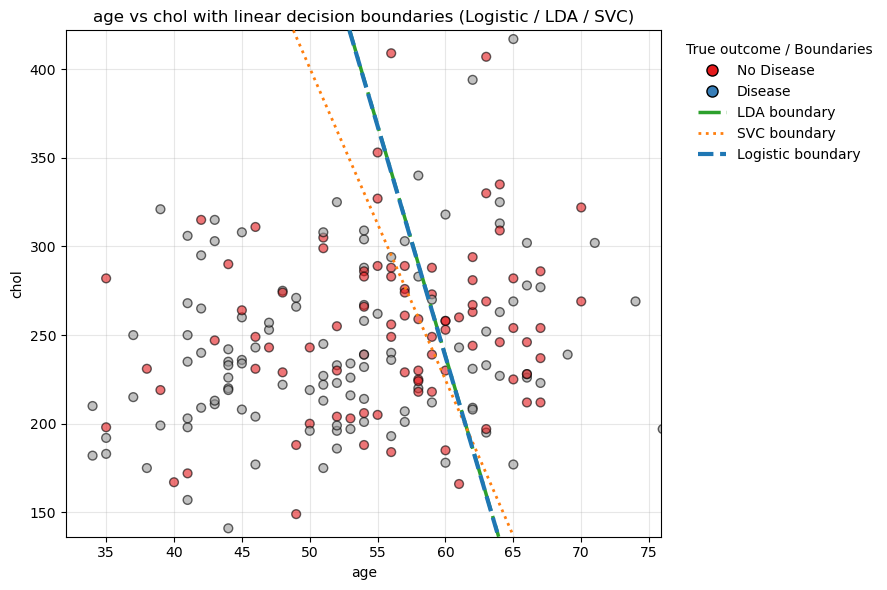

In [99]:
ax.set_xlabel(xname); ax.set_ylabel(yname)
ax.set_title("age vs chol with linear decision boundaries (Logistic / LDA / SVC)")
ax.grid(True, alpha=0.3)
ax.set_aspect("auto")
ax.set_xlim(xs.min(), xs.max()); ax.set_ylim(ys.min(), ys.max())

combined = list(class_handles) + list(boundary_handles)
seen, dedup = set(), []
for h in combined:
    lab = h.get_label()
    if lab not in seen:
        dedup.append(h); seen.add(lab)

ax.legend(handles=dedup, title="True outcome / Boundaries",
          loc="upper left", bbox_to_anchor=(1.02, 1), frameon=False)

plt.tight_layout()
plt.show()